# Example csaQTL GWAS

## Prepare the input single-cell data object

In [1]:
import numpy as np
import pandas as pd
import multianndata as mad
import cna
import scanpy as sc
import matplotlib.pyplot as plt
np.random.seed(0)
tutorial_folder="/data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/"

__Import data__:
- __cellsXgenes__: A matrix with one row per cell containing cell profiling information (e.g., gene expression). In this tutorial, we treat this object as if it has already undergone quality control and standard processing in preparation for nearest-neighbor graph construction (e.g., total count normalization, selection of variable genes, logarithmizing of counts, and scaling). Examples of such processing can be found in scanpy tutorials (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
- __cell_meta__: A matrix with one row per cell storing cell metadata. At a minimum, this object should contain cell assignments to donors in a column titled 'id'.
- __sample_meta__: A matrix with one row per donor (i.e., one row per sample) storing all covariate information to be used in the csaQTL GWAS as well as batch information, if relevant. The donor ids in this file should match those in cell_meta['id'] as well as the genotyping data.

In [2]:
# Note that this file must first be unzipped
cellsXgenes = pd.read_table("data/cellsXgenes.tsv", index_col = 0)
cellsXgenes.head(3)

,Gene_0,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_110,Gene_111,Gene_112,Gene_113,Gene_114,Gene_115,Gene_116,Gene_117,Gene_118,Gene_119
cell_0,1.770456,0.399407,0.977176,2.236188,1.868089,-0.977097,0.952328,-0.151485,-0.103624,0.411872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell_1,-0.674902,-0.358879,-0.811849,-1.722658,0.177477,-0.401707,-1.634041,0.463172,-0.910861,0.052107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell_2,0.377792,-1.097339,0.297762,1.323601,-0.694765,-0.149607,-0.436179,1.850822,0.674935,0.408726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
cell_meta = pd.read_table("data/cell_meta.tsv", index_col = 0)
cell_meta.head(3)

,clust1,clust2,clust3,id
cell_0,1.0,0.0,0.0,Donor_77
cell_1,1.0,0.0,0.0,Donor_72
cell_2,1.0,0.0,0.0,Donor_43


In [4]:
sample_meta = pd.read_table("data/sample_meta.tsv", index_col=0)
sample_meta.head(3)

,Age,Sex,gPC1,gPC2,gPC3,gPC4,gPC5,batch
Donor_0,20,0,-0.396074,1.868933,-1.470054,-2.159593,1.347588,0
Donor_1,22,1,-0.021647,-0.306500,-1.050671,0.498723,-0.075123,0
Donor_2,48,0,-0.896717,-0.518595,-0.418579,0.097400,0.184382,0


We create a MultiAnnData object containing the single-cell profiling and donor covariate information. We also generate the nearest neighbor graph and NAM-PCs for this object. Batch correction should also be applied to this object, if relevant to the dataset, but is not illustated here.

We specify when making the MultiAnnData object that the donor identifiers are stored the column of cell_meta titled 'id'.

In [5]:
# Make MultiAnnData object
d = mad.MultiAnnData(X = cellsXgenes, obs = cell_meta, sampleid = 'id')

# Add all covariate information to d.samplem
d.samplem = d.samplem.join(sample_meta)

# Define nearest neighbor graph and UMAP
sc.pp.pca(d)
sc.pp.neighbors(d)
sc.tl.umap(d)

# Define neighborhood abundance matrix (NAM) and NAM-PCs
cna.tl.nam(d)

['id']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies


In [6]:
d.write(tutorial_folder+"data/scDataObject.h5ad")

/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'id' as categorical


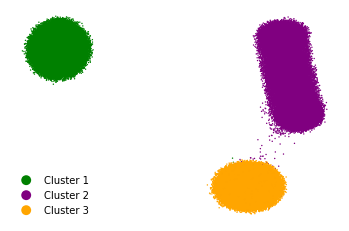

In [7]:
# Visualize data
plt.scatter(d.obsm['X_umap'][d.obs.clust1==1,0], d.obsm['X_umap'][d.obs.clust1==1,1], 
            c="green", edgecolor='none', s=2, label = "Cluster 1")
plt.scatter(d.obsm['X_umap'][d.obs.clust2==1,0], d.obsm['X_umap'][d.obs.clust2==1,1], 
            c="purple", edgecolor='none', s=2, label = "Cluster 2")
plt.scatter(d.obsm['X_umap'][d.obs.clust3==1,0], d.obsm['X_umap'][d.obs.clust3==1,1], 
            c="orange", edgecolor='none', s=2, label = "Cluster 3")
plt.legend(loc="lower left", markerscale=7, frameon=False)
plt.axis("off")
plt.show()

## Apply GeNA to run a csaQTL GWAS

GeNA is a command-line tool. To include all tutorial components here, we call GeNA from within this notebook.

First, we navigate to the folder housing the GeNA scripts.

In [8]:
cd /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/

/data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA


Then we run GeNA, specifying:
- __-s__ the path to the __single-cell object__ in MultiAnnData format as demonstrated above
- __-b__ whether or not to use sample assignments to batches stored in a d.samplem column titled __'batch'__ to remove batchy neighborhoods
- __-g__ a path to __genotyping__ data in PLINK2 format 
- __-o__ a path to an __output folder__ for GeNA sumstats
- __-c__ a list of __covariates__ to control for when running GeNA. Expected format is a comma-delimited list of column names stored in d.samplem
- __-k__ (Optional) a path to a file with user-specified values of k for GeNA to consider, formatted with one value of k on each line

This command, in full, for our tutorial data is:

./GeNA.sh -s /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/data/scDataObject.h5ad -b 'True' -g /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/data/gtypes -o /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/output/ -c 'Age,Sex,gPC1,gPC2,gPC3,gPC4,gPC5'

In [9]:
!./GeNA.sh -s /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/data/scDataObject.h5ad -b 'True' -g /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/data/gtypes -o /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/output/ -c 'Age,Sex,gPC1,gPC2,gPC3,gPC4,gPC5'

Arguments provided:
Genotypes: /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/data/gtypes 
Single-cell data object: /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/data/scDataObject.h5ad 
Output folder: /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/output/ 
Correct for batch: True 
Covariates: Age,Sex,gPC1,gPC2,gPC3,gPC4,gPC5
Values of k: Default


Formatting input for PLINK
plink2 --pfile /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/data/gtypes --pheno /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/output/nampcs.csv --glm --prune --out /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/output/plink_per_nampc/NAM
PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA/tutorial/output/plink_per_nampc/NAM.log.
Options in effect:
  --glm
  --out /data/srlab/lrumker/MCSC_Project/cna-qtl/G

The GeNA output file of summary statistics includes the following information:
- The chromosome (__#CHROM__), position (__POS__), __ID__, __REF__erence and __ALT__ernative (tested as effect allele __A1__) alleles for each tested variant
- The number of donors (__OBS_CT__) included in the test
- The GeNA __P__-value
- The value of __k__ from the best-performing model for that variant considered by GeNA
- The fitted coefficients per NAM-PC (__BETA_NAMPC*__)

In [10]:
sumstats = pd.read_table(tutorial_folder+"output/GeNA_sumstats.txt")
sumstats.head(3)

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,P,k,BETA_NAMPC1,BETA_NAMPC2,BETA_NAMPC3,BETA_NAMPC4
0,1,100,rs98517,A,T,T,ADD,100,0.763551,4,0.000617,0.000122,0.027196,0.011841
1,1,101,rs95658,A,T,T,ADD,100,0.316096,1,-0.022417,0.018093,0.010341,-0.011499
2,1,102,rs55753,A,T,T,ADD,100,0.356863,1,-0.021197,-0.020500,0.004479,-0.007396


We can see that two loci are detected as csaQTLs in the simulated tutorial data.

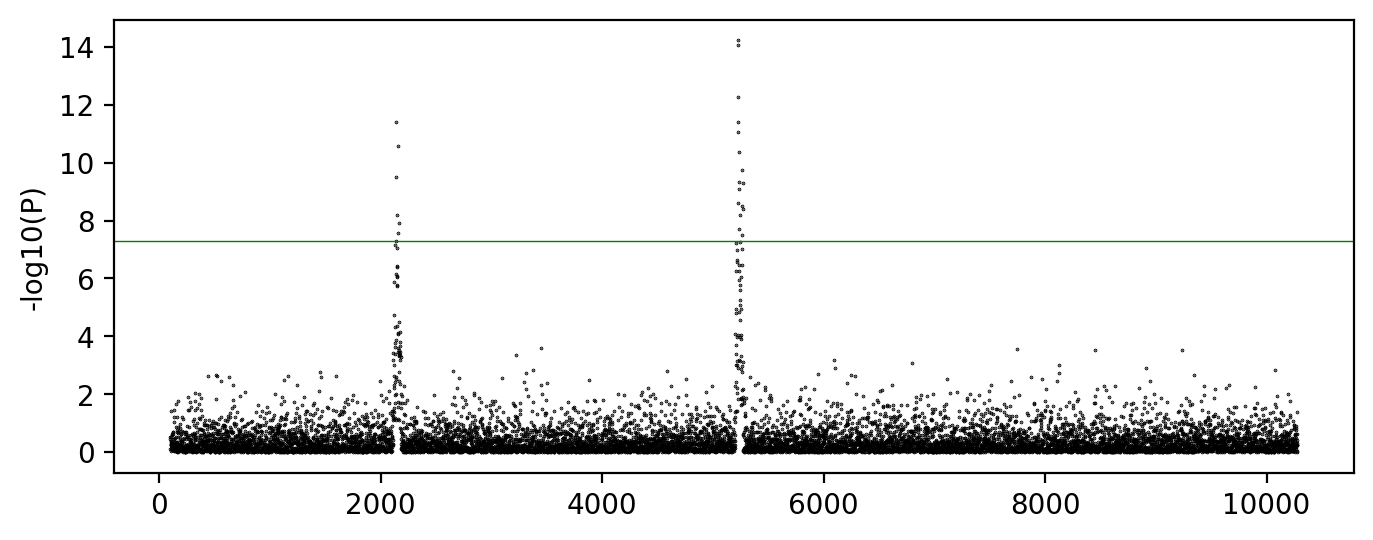

In [11]:
# visualize
fig = plt.figure(figsize=(8,3), dpi = 200)
plt.scatter(sumstats.POS.values, -np.log10(sumstats.P), s = 0.1, c = "black")
plt.ylabel("-log10(P)")
plt.axhline(y=-np.log10(5e-8), lw = 0.5, c = "green")
plt.show()

## Characterization of tutorial csaQTLs

Please refer to immunogenomics/GeNA-applied for additional examples of csaQTL characterization. We illustrate here a basic characterization of the two found loci in our simulated tutorial data.

If we define the most strongly associated SNP in each locus as the lead SNP, then the lead SNPs in the tutorial data are __rs39134__ and __rs20184__.

We apply CNA to define abundance correlations per neighborhood ("neighborhood-level phenotype") for each lead SNP, ensuring batch and covariate control is the same as in the discovery csaQTL GWAS with GeNA. (Note that the p-value and k values from this call to CNA can be ignored and do not affect the neighborhood-level phenotype reported.)

For more information on running CNA, please refer to our tutorial here: https://github.com/immunogenomics/cna/blob/master/demo/demo.ipynb

Note that abundance correlations per neighborhood are only quantified for non-batchy neighborhoods (d.uns['keptcells'])

In [12]:
# Here we add dose values for the lead SNPs to d.samplem
gtypes = pd.read_table(tutorial_folder+"data/gtypes.vcf.gz", 
                       skiprows = 13).set_index('ID', drop=True).loc[['rs39134','rs20184'],:].iloc[:,8:]

In [13]:
gtypes.iloc[0,:] = np.array([float(gtypes.iloc[0,i].split(":")[1]) for i in np.arange(gtypes.shape[1])])
gtypes.iloc[1,:] = np.array([float(gtypes.iloc[1,i].split(":")[1]) for i in np.arange(gtypes.shape[1])])
d.samplem = d.samplem.join(gtypes.T.rs39134.astype(float))
d.samplem = d.samplem.join(gtypes.T.rs20184.astype(float))

In [14]:
res = cna.tl.association(d, d.samplem['rs20184'], batches = d.samplem.batch,
                         covs = d.samplem[['Age','Sex','gPC1','gPC2','gPC3','gPC4','gPC5']])
npheno = res.ncorrs #neighborhood-level phenotype
kept = d.uns['keptcells']

/data/srlab/lrumker/MCSC_Project/cna/src/cna/tools/_association.py:79: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


We can see that our first locus associates primarily with a depletion of abundance in cluster 1 relative to the other two clusters.

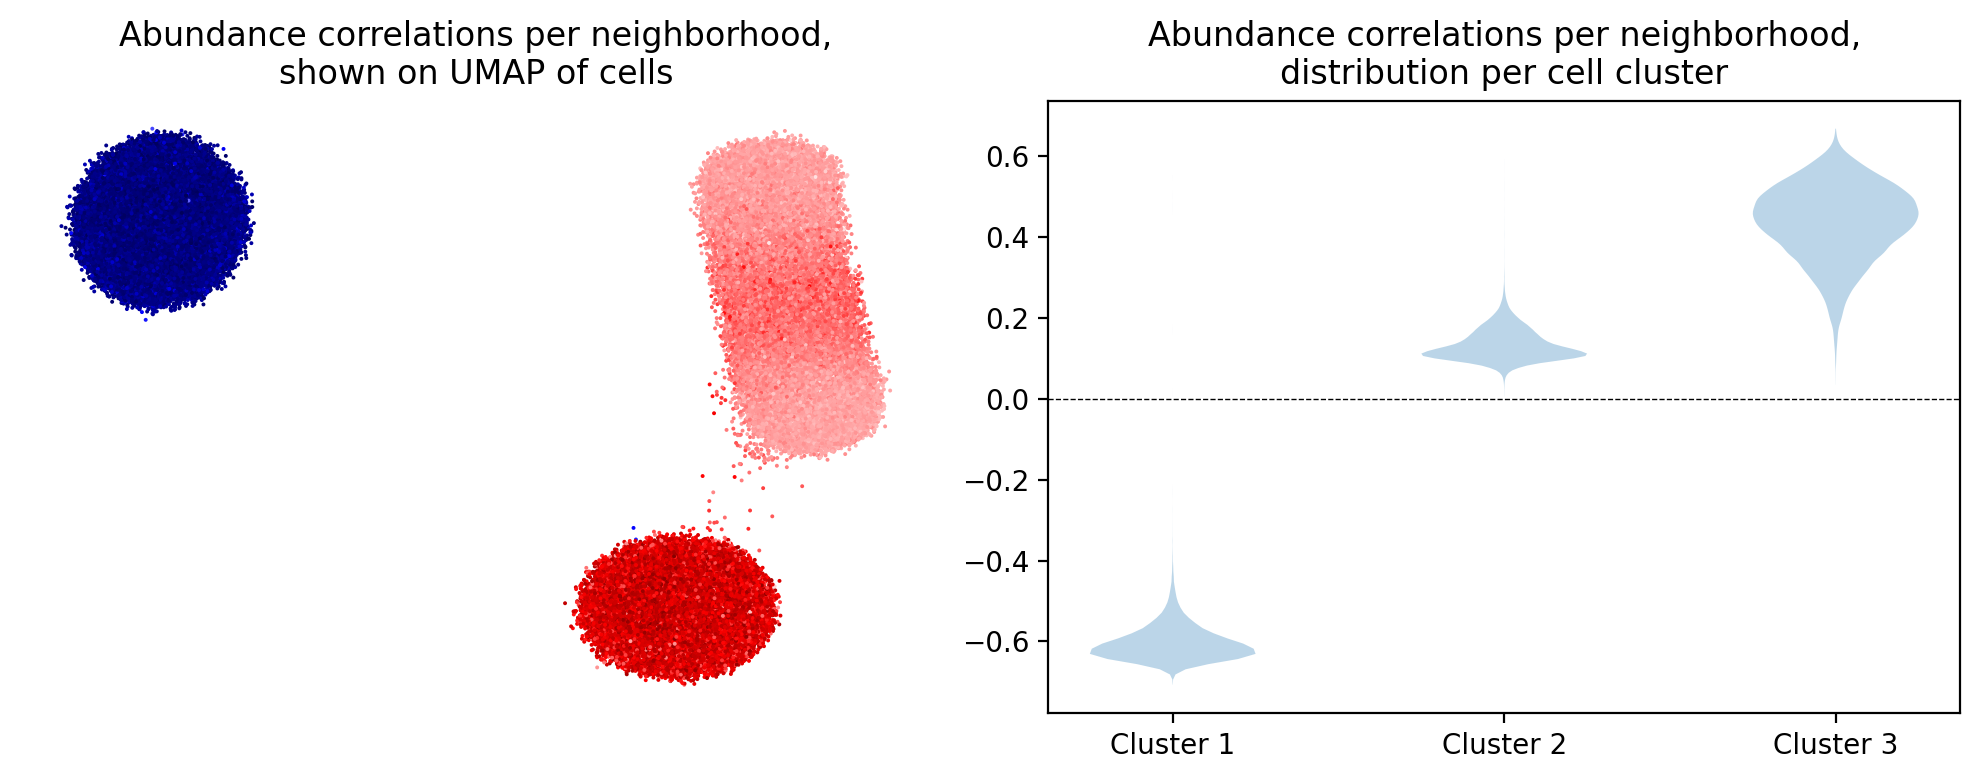

In [15]:
fig, axes = plt.subplots(1,2, figsize=(10,4), dpi = 200)
axes[0].scatter(d.obsm['X_umap'][kept,0], d.obsm['X_umap'][kept,1], c=npheno, edgecolor='none', 
                s=2, cmap = "seismic")
axes[0].axis("off")
axes[0].set_title("Abundance correlations per neighborhood,\nshown on UMAP of cells")
axes[1].violinplot([npheno[d.obs.clust1[kept]==1], npheno[d.obs.clust2[kept]==1], npheno[d.obs.clust3[kept]==1]],
              showmeans=False, showextrema=False, showmedians=False)
axes[1].axhline(y=0, c = 'black', lw=0.5, ls="--")
axes[1].set_title("Abundance correlations per neighborhood,\ndistribution per cell cluster")
axes[1].set_xticks([1,2,3])
axes[1].set_xticklabels(["Cluster 1","Cluster 2","Cluster 3"])
plt.tight_layout()
plt.show()

In [16]:
res = cna.tl.association(d, d.samplem['rs39134'], batches = d.samplem.batch,
                         covs = d.samplem[['Age','Sex','gPC1','gPC2','gPC3','gPC4','gPC5']])
npheno = res.ncorrs #neighborhood-level phenotype

We can see that our second locus associates with an abundance shift within cluster 2.

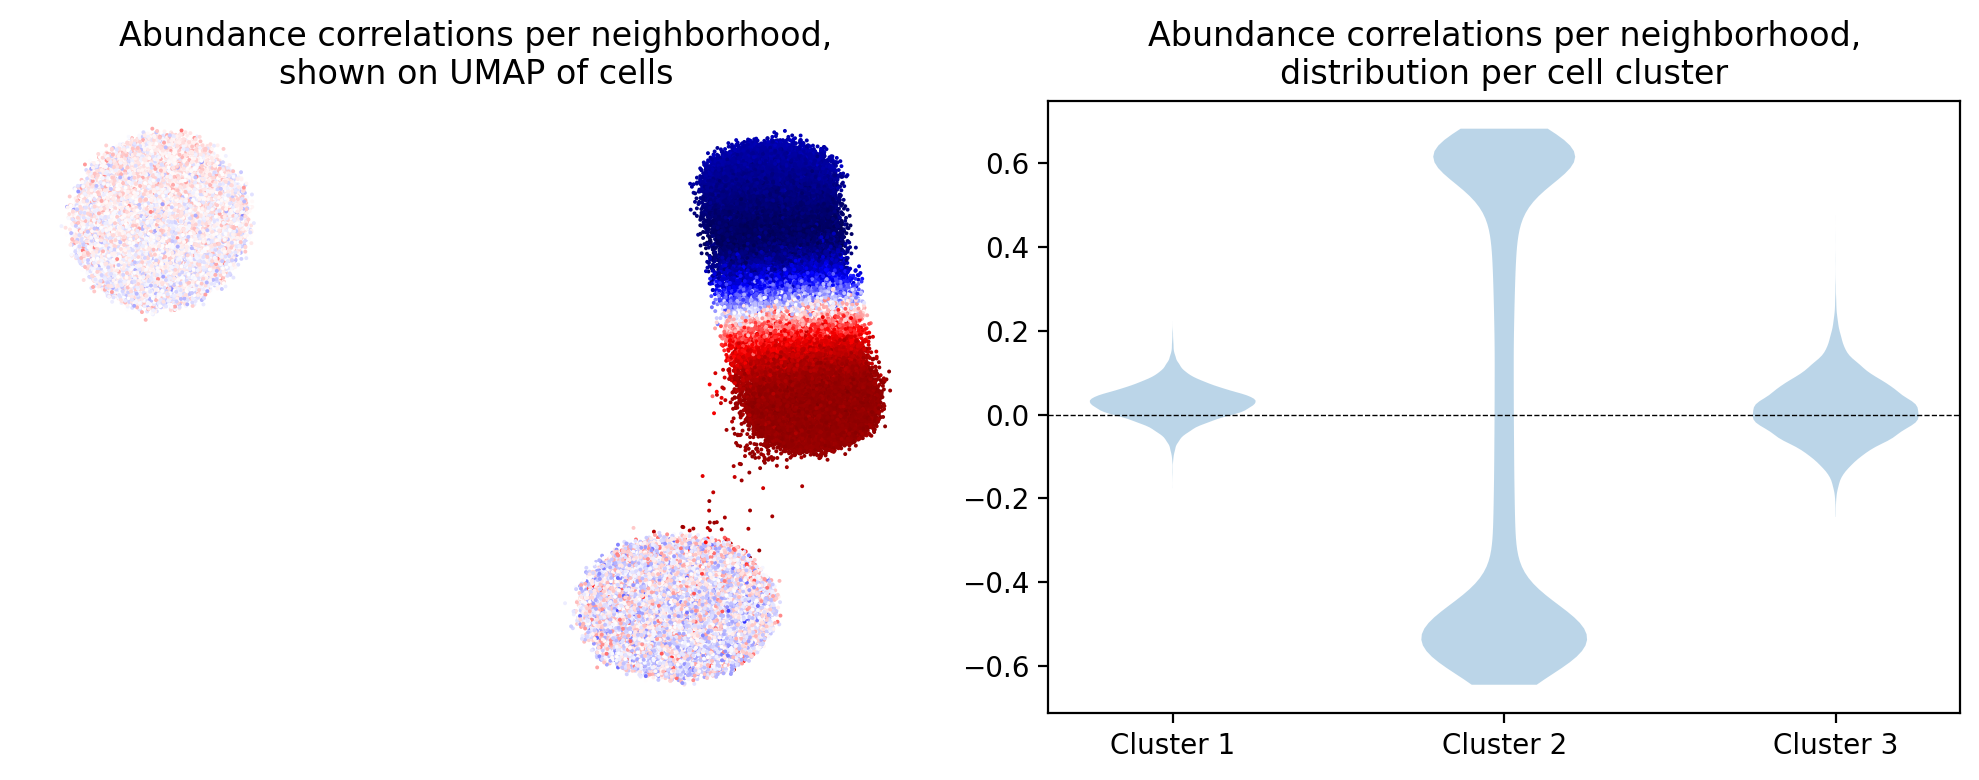

In [17]:
fig, axes = plt.subplots(1,2, figsize=(10,4), dpi = 200)
axes[0].scatter(d.obsm['X_umap'][kept,0], d.obsm['X_umap'][kept,1], c=npheno, edgecolor='none', 
                s=2, cmap = "seismic")
axes[0].axis("off")
axes[0].set_title("Abundance correlations per neighborhood,\nshown on UMAP of cells")
axes[1].violinplot([npheno[d.obs.clust1[kept]==1], npheno[d.obs.clust2[kept]==1], npheno[d.obs.clust3[kept]==1]],
              showmeans=False, showextrema=False, showmedians=False)
axes[1].axhline(y=0, c = 'black', lw=0.5, ls="--")
axes[1].set_title("Abundance correlations per neighborhood,\ndistribution per cell cluster")
axes[1].set_xticks([1,2,3])
axes[1].set_xticklabels(["Cluster 1","Cluster 2","Cluster 3"])
plt.tight_layout()
plt.show()

And examination of cell-level features reveals the geneset that characterizes the subset of cells that are depleted within cluster 2 among individuals with higher dose of the effect allele.

In [18]:
vargene_cors = pd.DataFrame({"gene": d.var.index,
                            "cor": [np.corrcoef(d.X[kept,i], npheno)[0,1] for i in np.arange(d.var.shape[0])]})
geneset = vargene_cors.iloc[np.argsort(-1*(vargene_cors.cor.values**2)),:].head(10).gene.values
i_geneset = [np.where(d.var.index==geneset[i])[0][0] for i in np.arange(len(geneset))]

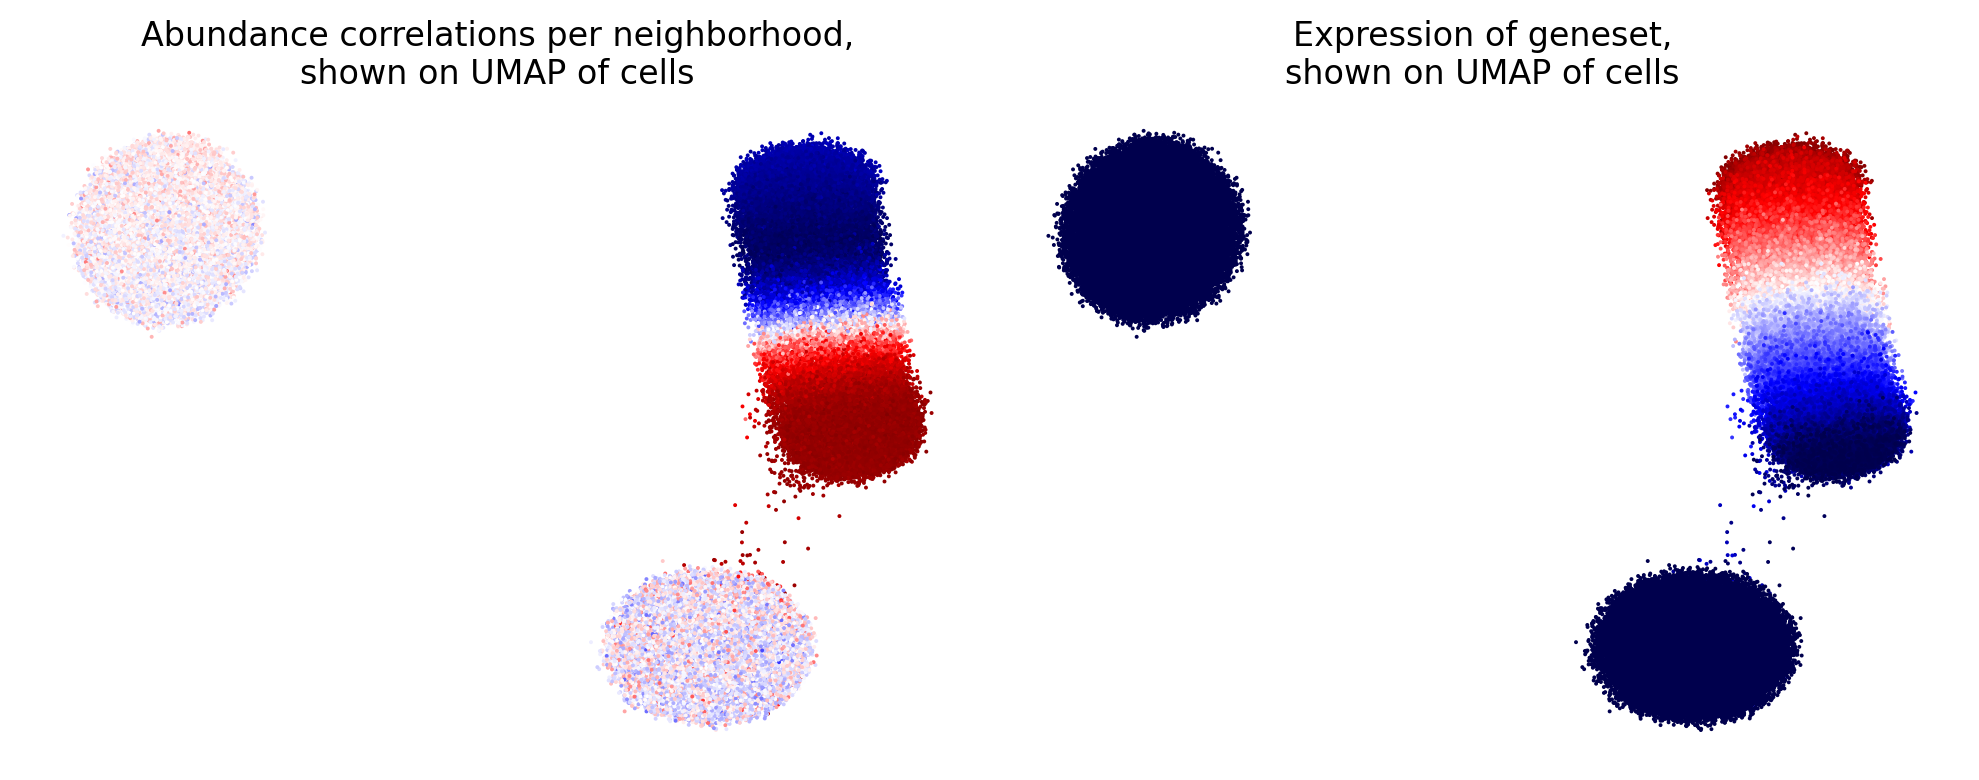

In [19]:
fig, axes = plt.subplots(1,2, figsize=(10,4), dpi = 200)
axes[0].scatter(d.obsm['X_umap'][kept,0], d.obsm['X_umap'][kept,1],  
            c=npheno, edgecolor='none', s=2, cmap = "seismic")
axes[0].axis("off")
axes[0].set_title("Abundance correlations per neighborhood,\nshown on UMAP of cells")
axes[1].scatter(d.obsm['X_umap'][kept,0], d.obsm['X_umap'][kept,1],  
            c=d.X[kept,:][:,i_geneset].sum(axis=1), edgecolor='none', s=2, cmap = "seismic")
axes[1].axis("off")
axes[1].set_title("Expression of geneset,\nshown on UMAP of cells")
plt.tight_layout()
plt.show()